## Exercise 1

**Task:** *Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?*

In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import notebook

RANDOM_SEED = 30

%matplotlib inline
sns.set_theme()

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10] #slicing the first 10 indexes of the list

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
print(f"Number of names: {len(words):,}")

Number of names: 32,033


In [4]:
# Retrieving a set of unique letters
chars = sorted(list(set(''.join(words))))

# Creating a mapping from a letter to an id
char2id = {s: i+1 for i, s in enumerate(chars)}
# Adding the start_of_word/end_of_word token => "."
char2id['.'] = 0

# Creating a mapping from an id to letter
id2char = {i: s for s, i in char2id.items()}

In [5]:
char2id

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [6]:
id2char

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Biagram Model

In [7]:
# Creating the dataset

X_bigram, Y_bigram = [], []

for word in words:
    # Adding special token for the start and end of each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2 in zip(chars, chars[1:]):
        # Getting the indices of a letter
        index_1 = char2id[char_1]
        index_2 = char2id[char_2]
        
        # Adding letter indices to lists
        X_bigram.append(index_1)
        Y_bigram.append(index_2)
    
# Changing them to PyTorch tensors
X_bigram = torch.tensor(X_bigram)
Y_bigram = torch.tensor(Y_bigram)

In [8]:
print(X_bigram)
print(Y_bigram)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


Now, we have a dataset where we know the next letter based on the previous one. 

In [9]:
class BigramModel:
    def __init__(
        self, 
        num_features, 
        num_outputs, 
        num_epochs, 
        learning_rate,
        logging=False,
        regularize=False, 
        smooth_strength=None, 
        seed=2147483647,
        enable_tqdm=True,
        *args,
        **kwargs,
    ):
        """Initializes BigramModel instance."""
        # Creating class attributes
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.logging = logging
        self.regularize = regularize
        self.smooth_strength = smooth_strength
        self.seed = seed
        self.enable_tqdm = enable_tqdm
        # Generating random weights based on a random seed
        generator = torch.Generator().manual_seed(self.seed)
        self.weights = torch.randn((self.num_features, self.num_outputs), generator=generator)
        self.weights.requires_grad = True
        
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        # One-hot encoding NN inputs
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float()
        # Computing predictions for log-counts
        logits = x_encoded @ self.weights
        # Retrieving counts
        counts = logits.exp()
        # Computing probabilities for the next character
        probas = counts / counts.sum(1, keepdims=True)
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def fit(self, x, y):
        """Fits the NN to data."""
        # Preallocating a dict for storing loss across epochs
        loss_per_epoch = {}
        # Utilizing a progress bar when training or not
        epoch_counter = notebook.tqdm(range(self.num_epochs)) if self.enable_tqdm else range(self.num_epochs)
        for k in epoch_counter:
            # Making a forward pass and computing a loss
            loss = self(x, y)
            # Adding a loss computed to the history
            loss_per_epoch[f"epoch_{k+1}"] = loss.item()
            # Logging progress
            if self.logging:
                print(f"Epoch {k + 1:03d}/{self.num_epochs:03d}: loss = {loss.item():.4f}")
            
            # Setting gradients to zero
            self.weights.grad = None
            # Making a backward pass (initiating backpropagation)
            loss.backward()
            
            # Updating weights (SGD)
            self.weights.data -= self.learning_rate * self.weights.grad
        
        # Creating an attribute for training history after training
        self.history = loss_per_epoch
    
    def generate_sample(self, num_examples, id2char):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        # Preallocating a list for storing generated names
        generated_names = []
        for i in range(num_examples):
            # Preallocating a list for storing letters
            out = []
            # Starting names generation with "."
            ix = 0
            while True:
                # Computing probabilities for the next character
                x_encoded = F.one_hot(torch.tensor([ix]), num_classes=self.num_outputs).float()
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                # Retrieving a letter index from the probability distribution
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the letter to a list
                out.append(id2char[ix])
                # Iterating until "." is encountered
                if ix == 0:
                    break
            
            # Joining letters together to compose a word and add to other examples
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

In [10]:
# Instantiating a bigram model
bigram_model = BigramModel(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
bigram_model.fit(X_bigram, Y_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
bigram_model.generate_sample(num_examples=10, id2char=id2char)

['junide',
 'janasah',
 'p',
 'cfay',
 'a',
 'nn',
 'kohin',
 'tolian',
 'juwe',
 'kalanaauranilevias']

## Trigram Model

Lets create a dataset that takes the first two characters as the input and uses that information to predict the third character

In [12]:
X_trigram, Y_trigram = [], []
for word in words:
    # Adding special token for each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2, char_3 in zip(chars, chars[1:], chars[2:]):
        # Getting the indices of a letter
        index_1 = char2id[char_1]
        index_2 = char2id[char_2]
        index_3 = char2id[char_3]
        
        # Adding letter indices to lists
        X_trigram.append([index_1, index_2])
        Y_trigram.append(index_3)

# Casting as PyTorch tensors
X_trigram = torch.tensor(X_trigram)
Y_trigram = torch.tensor(Y_trigram)

In [13]:
print(X_trigram)
print(Y_trigram)

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])
tensor([13, 13,  1,  ..., 26, 24,  0])


In [14]:
class TrigramModel(BigramModel):
    def __init__(self, *args, **kwargs):
        """Inherits initialization schema from BigramModel class."""
        super().__init__(*args, **kwargs)
    
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        x_encoded = F.one_hot(x, num_classes=self.num_outputs).float().view(-1, self.num_features)
        logits = x_encoded @ self.weights # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probas = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect.")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def generate_sample(self, num_examples, id2char):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        generated_names = []
        for i in range(num_examples):
            out = []
            # Initializing the starting sequence
            context = [0, 0] 
            while True:
                x_encoded = F.one_hot(torch.tensor([context]), num_classes=self.num_outputs).float().view(1, -1)
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the predicted character and shifting
                context = context[1:] + [ix]
                out.append(id2char[ix])
                if ix == 0:
                    break
                    
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

In [15]:
# Instantiating a trigram model
trigram_model = TrigramModel(
    num_features=54, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
trigram_model.fit(X_trigram, Y_trigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
trigram_model.generate_sample(num_examples=10, id2char=id2char)

['aunide',
 'aliasad',
 'ushfay',
 'ainn',
 'aui',
 'ritoleras',
 'get',
 'usannaauranileniassibdainrwi',
 'ol',
 'seisiely']

### Comparison

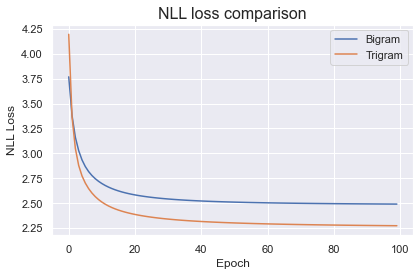

In [17]:
# Losses obtained during training bigram/trigram models
loss_histories = {
    "Bigram": bigram_model.history.values(),
    "Trigram": trigram_model.history.values(),
}

# Joining results in a DataFrame
comparison_df = pd.DataFrame(loss_histories)

# Plotting the comparison
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison", fontsize=16)
plt.tight_layout()
plt.show()

## Exercise 2

Task: Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [18]:
len(words)

32033

In [19]:
random.seed(42)
random.shuffle(words)

cutoff_train = int(0.8 * len(words))
cutoff_dev = int(0.9 * len(words))

print(f"Training set: {0}-{cutoff_train - 1}")
print(f"Development set: {cutoff_train}-{cutoff_dev - 1}")
print(f"Testing set: {cutoff_dev}-{len(words)}")

Training set: 0-25625
Development set: 25626-28828
Testing set: 28829-32033


In [20]:
# Allocating shuffled words into three sets
words_train = words[:cutoff_train]
words_dev = words[cutoff_train:cutoff_dev]
words_test = words[cutoff_dev:]

print(f"Training set examples: {len(words_train):,} ({len(words_train)/len(words):.0%})")
print(f"Development set examples: {len(words_dev):,} ({len(words_dev)/len(words):.0%})")
print(f"Testing set examples: {len(words_test):,} ({len(words_test)/len(words):.0%})")

Training set examples: 25,626 (80%)
Development set examples: 3,203 (10%)
Testing set examples: 3,204 (10%)


In [21]:
def build_datasets(words, train_set=0.8, dev_set=0.1, test_set=0.1, context_size=2, seed=42):
    """
    Splits words into train, dev, and test datasets with N-gram context.

    Args:
        words (list): List of words.
        train_set (float): Fraction of words to use for training.
        dev_set (float): Fraction of words to use for validation.
        test_set (float): Fraction of words to use for testing.
        context_size (int): Number of previous characters to consider as context.
        seed (int): Random seed for reproducibility.

    Returns:
        (tuple): X_train, Y_train, X_dev, Y_dev, X_test, Y_test as torch tensors.
    """
    if not (0 <= train_set <= 1 and 0 <= dev_set <= 1 and 0 <= test_set <= 1):
        raise ValueError("Error: train_set, dev_set, and test_set must be between 0 and 1.")
    
    if train_set + dev_set + test_set != 1:
        raise ValueError("Error: The fractions assigned to train, dev, and test must add up to 1.")

    random.seed(seed)
    random.shuffle(words)

    train_end = int(train_set * len(words))
    dev_end = train_end + int(dev_set * len(words))

    train_words, dev_words, test_words = words[:train_end], words[train_end:dev_end], words[dev_end:]

    def process_dataset(word_list, context_size):
        X, Y = [], []
        for word in word_list:
        # Creating a starting examples depending on block size
            context = [0] * context_size
            # Iterating through entire word with end of word token
            for char in word + '.':
                index = char2id[char]
                X.append(context)
                Y.append(index)
                # Adding the character index and shifting
                context = context[1:] + [index]
                
        if context_size == 1:
            X = torch.tensor(X).view(-1)
        else:
            X = torch.tensor(X)
        
        return X, torch.tensor(Y, dtype=torch.long)  

    X_train, Y_train = process_dataset(train_words, context_size)
    X_dev, Y_dev = process_dataset(dev_words, context_size)
    X_test, Y_test = process_dataset(test_words, context_size)

    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

In [22]:
Trigram_datasets = build_datasets(words)
Bigram_datasets = build_datasets(words, context_size=1)

In [23]:
### Trigram Training

X_train, Y_train, X_dev, Y_dev, X_test, Y_test = Trigram_datasets

trigram_model = TrigramModel(
    num_features=54, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
trigram_model.fit(X_train, Y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
trigram_train_loss = trigram_model(X_train, Y_train).item()
trigram_dev_loss = trigram_model(X_dev, Y_dev).item()
trigram_test_loss = trigram_model(X_test, Y_test).item()

print(f"Train loss: {trigram_train_loss:.4f}")
print(f"Dev loss: {trigram_dev_loss:.4f}")
print(f"Test loss: {trigram_test_loss:.4f}")

Train loss: 2.3943
Dev loss: 2.3933
Test loss: 2.4000


In [25]:
### Bigram  Training

X_train, Y_train, X_dev, Y_dev, X_test, Y_test = Bigram_datasets

bigram_model = BigramModel(
    num_features=27, 
    num_outputs=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
bigram_model.fit(X_train, Y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
bigram_train_loss = bigram_model(X_train, Y_train).item()
bigram_dev_loss = bigram_model(X_dev, Y_dev).item()
bigram_test_loss = bigram_model(X_test, Y_test).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

Train loss: 2.4883
Dev loss: 2.4975
Test loss: 2.4978


In [27]:
losses = {
    "bigram_loss": [bigram_train_loss, bigram_dev_loss, bigram_test_loss],
    "trigram_loss": [trigram_train_loss, trigram_dev_loss, trigram_test_loss]
}

index = ["train", "dev", "test"]
loss_set_df = pd.DataFrame(losses, index=index).round(4)
loss_set_df

,bigram_loss,trigram_loss
train,2.4883,2.3943
dev,2.4975,2.3933
test,2.4978,2.4000


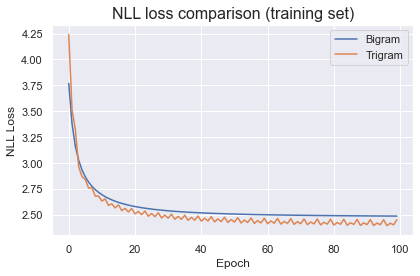

In [28]:
# Losses obtained during training bigram/trigram models
loss_histories = {
    "Bigram": bigram_model.history.values(),
    "Trigram": trigram_model.history.values(),
}

# Joining results in a DataFrame
comparison_df = pd.DataFrame(loss_histories)

# Plotting the comparison
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison (training set)", fontsize=16)
plt.tight_layout()
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

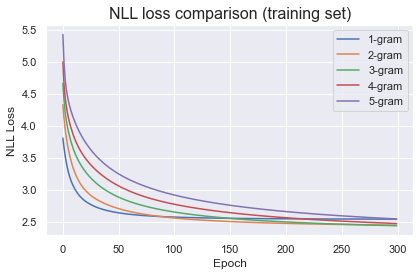

In [29]:
test_loss = []  
loss_histories = {}  
models = {}  

for i in range(1, 6): 
    datasets = build_datasets(words, context_size=i)
    X_train, Y_train, X_dev, Y_dev, X_test, Y_test = datasets

    model = TrigramModel(
        num_features=27 * i,  
        num_outputs=27,
        num_epochs=300,  
        learning_rate=50 / (i * 3),  
        logging=False,  
        regularize=True,  
        smooth_strength=0.01 * (5 * i)
    )

    model.fit(X_train, Y_train)

    loss = model(X_test, Y_test).item()
    test_loss.append(loss)

    models[f"Model_{i}gram"] = model
    loss_histories[f"{i}-gram"] = list(model.history.values())

comparison_df = pd.DataFrame(loss_histories)

# ✅ Plot the losses
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison (training set)", fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
print(test_loss)

[2.5388906002044678, 2.456165075302124, 2.4440526962280273, 2.468397617340088, 2.5623390674591064]


We can see here that the test loss can decrease even further by taking in a higher context window if the variables affecting the model (i.e. learning rate, epochs, smooth strength) are tuned properly

## Exercise 3

Task: Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [37]:
strengths = np.arange(0, 0.11, 0.01)
strengths

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [41]:
Trigram_datasets = build_datasets(words)
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = Trigram_datasets

best_dev_loss = np.Inf
best_strength = 0
best_model = None

for strength in strengths:
    model = TrigramModel(
        num_features=54, 
        num_outputs=27,
        num_epochs=100,
        learning_rate=50, 
        regularize=True, 
        smooth_strength=strength,
        enable_tqdm=False,
    )
    
    # Training
    model.fit(X_train, Y_train)
    
    train_loss = model(X_train, Y_train).item()
    dev_loss = model(X_dev, Y_dev).item()
    
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        best_strength = strength
        best_model = model

    print(f"strength = {strength:.2f}: train_loss = {train_loss:.4f}, dev_loss = {dev_loss:.4f}")
    
print(f"\nBest dev loss: {best_dev_loss:.4f}")
print(f"Best strength: {best_strength:.2f}")

test_loss = best_model(X_test, Y_test).item()
print(f"\nTest set loss: {test_loss:.4f}")

strength = 0.00: train_loss = 2.3866, dev_loss = 2.3908
strength = 0.01: train_loss = 2.3950, dev_loss = 2.3991
strength = 0.02: train_loss = 2.4026, dev_loss = 2.4066
strength = 0.03: train_loss = 2.4095, dev_loss = 2.4133
strength = 0.04: train_loss = 2.4158, dev_loss = 2.4195
strength = 0.05: train_loss = 2.4216, dev_loss = 2.4252
strength = 0.06: train_loss = 2.4270, dev_loss = 2.4305
strength = 0.07: train_loss = 2.4320, dev_loss = 2.4355
strength = 0.08: train_loss = 2.4368, dev_loss = 2.4402
strength = 0.09: train_loss = 2.4414, dev_loss = 2.4446
strength = 0.10: train_loss = 2.4457, dev_loss = 2.4489

Best dev loss: 2.3908
Best strength: 0.00

Test set loss: 2.3859


The best model is one with no regularization at all, bringing in the question whether perhaps training the model for longer might help decrease loss in further

## Exercise 4

**Task:** *We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?*

In [44]:
class BigramModelV2(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        # Computing predictions for log-counts (THE ONLY CHANGE)
        logits = self.weights[x]
        # Retrieving counts
        counts = logits.exp()
        # Computing probabilities for the next character
        probas = counts / counts.sum(1, keepdims=True)
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss